Processing the frequency spectrum of a pulse into time lag series

In [1]:
import numpy as np
from scipy.stats.stats import pearsonr
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.time import Time

from os.path import exists 
from GPbaseband1 import *

#Using latex rendering:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

if exists('./figures/correlation_coeff/giant_pulses{}chan.npz'.format(nchan)):
    with np.load('./figures/correlation_coeff/giant_pulses{}chan.npz'.format(nchan)) as npzfile:
        freq_values = npzfile['freq_values']
        time_values = npzfile['time_values']
        noise_sigma_values = npzfile['noise_sigma_values']
    #load the giant pulse average smoothed and normalized:
    gpab=np.load('./figures/correlation_coeff/gpa_smoothed.npy')

/opt/python/2.7.10/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
with open('good_pulses.txt','w') as f:
    for i in range(259):
        f.write('{}\n'.format(time_values[i]))        

In [3]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


Loading a giant pulse 

In [99]:
def get_SN(outputsumfreq):
    noise_std = np.std(outputsumfreq[:5]) 
    noise_mean = np.mean(outputsumfreq[:5])
    sigs_noise = (outputsumfreq-noise_mean)/noise_std
    return sigs_noise

def load_gp(time_string,nchan):
    
    gp1 = np.load('/home/ramain/GPs/GPef/p{}.npy'.format(time_string))
    gp1t = np.fft.irfft(gp1,axis=1)
    gp1s = gp1t.reshape(-1,2*nchan,16)
    gp1s = np.fft.rfft(gp1s,axis=1)
    dchan = gp1s
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    output = (abs(dR)**2 + abs(dL)**2).T


    outputsumfreq = output.sum(0) #dedispersed
    #computes signal to noise after summing all the frequencies
    sigs_noise = get_SN(outputsumfreq)
    S_N = max(sigs_noise)

    peak_time = np.argmax(sigs_noise)
    
    background_freq = output[:,peak_time-5:peak_time-1].mean(1)
    
    output_pulse = output[:,peak_time]

    freq_spec = output_pulse-background_freq
    
    return freq_spec

text_name = 'good_pulses.txt'
with open(text_name, 'r') as f:
    text = f.read()
    text_lines = text.split('\n')

i = 34
fs = load_gp(text_lines[i-1],512)
fs.shape

(4104,)

In [11]:
nchan = 512
'''

'''
def process_freq_spec(gp1,index,draw=0):
    '''function takes a continuous frequency spectrum and cuts it into 8 bands, divide by the giant pulse mean, and normalize it by itself gp1=freq_spec[i]. function also plots the frequency spectrum'''
    gp1_8=np.zeros(shape=(0,425))
    for j in range(8):gp1_8=np.append(gp1_8,np.array([gp1[j*513+40:j*513+465]]),0)
    gp1_8/=gpab #Dividing by giant pulse average
    for i in range(8):gp1_8[i]=gp1_8[i]/gp1_8[i].mean()-1.
    if draw:
        f,axarr=plt.subplots(8,1,figsize=(10,15))

        for i in range(8):axarr[i].plot(gp1_8[i])
        axarr[0].set_title('Frequency spectrum of giant pulse at {}'.format(time_values[index]))
    return gp1_8

def transform_to_timelag(fgp,index,draw = 0):
    tgp=np.zeros(shape=(0,213))
    for i in range(8):tgp=np.append(tgp,np.array([np.fft.rfft(fgp[i])]),0)
    if draw:
        f,axarr=plt.subplots(8,1,figsize=(10,15))
        for i in range(8):axarr[i].plot(np.linspace(0,16,213),abs(tgp[i]))
        axarr[0].set_title('Time lag spectrum of giant pulse at {}'.format(time_values[index]))
        axarr[7].set_xlabel('Time lag(\mu s)')
    return tgp

def plotmean(tgp10):
    figure(figsize=(10,6))
    plot(np.linspace(0,16,213),abs(tgp10).mean(0))
    title('Mean of time lag spectrum')
    
def find_std(tgp,draw = 0):
    stda=np.std(tgp,axis=0) #numpy's std deals with complex numbers: std = sqrt(mean(abs(x - x.mean())**2)) 
    return stda
    if draw:
        figure(figsize=(10,6))
        plot(np.linspace(0,16,213),stda)
        title('Standard deviation as a function of time lag')

def plot_2_freq(fgp1,fgp2,index):
    '''index is an list of 2 indices'''
    f,axarr=plt.subplots(8,1,figsize=(10,15))
    for i in range(8):
        axarr[i].plot(fgp1[i])
        axarr[i].plot(fgp2[i])
    axarr[0].set_title('Frequency spectrum of giant pulse at {}, {}'.format(time_values[index[0]],time_values[index[1]]))
    axarr[7].set_xlabel('Frequency channels (512 channels per 16MHz = 0.03MHz per channel)')

def plot_2_timelag(tgp1,tgp2,index):
    '''index is an list of 2 indices'''
    f,axarr=plt.subplots(8,1,figsize=(10,15))
    for i in range(8):
        axarr[i].plot(np.linspace(0,15,213),abs(tgp1[i]))
        axarr[i].plot(np.linspace(0,15,213),abs(tgp2[i]))
    axarr[0].set_title('Time lag spectrum of giant pulse at {}, {}'.format(time_values[index[0]],time_values[index[1]]))
    axarr[7].set_xlabel(r'Time lag(\mu s)')


Plot the frequency spectrum and time lag spectrum of two giant pulses

In [5]:
plotmean(tgp2)
find_std(tgp2)

NameError: name 'tgp2' is not defined

Function to compute the correlation coefficient

In [88]:
def bin_data(t,a,bins):
    '''This function takes in t( an array of time values), a (array of data), and the bins and return an array of the binned data a'''
    a_binned = np.histogram(t,bins,weights = a,density = False)[0]/np.histogram(t,bins,density = False)[0]
    return a_binned 

def find_cc(i,j, binned = 0, bin_no=15):
    fgp1=process_freq_spec(freq_values[i-1],i,draw=0) #-1 if getting i from .txt file. i only needed for plotting
    tgp1=transform_to_timelag(fgp1,i-1,draw = 0)
    fgp2=process_freq_spec(freq_values[j-1],j,draw=0)
    tgp2=transform_to_timelag(fgp2,j-1,draw = 0)
    
    if binned:
        tgp1b = np.zeros(shape = (0,bin_no-1))
        tgp2b = np.zeros(shape = (0,bin_no-1))
        numerator_8 = np.zeros(shape = (0,bin_no-1))
    else:
        numerator_8 = np.zeros(shape = (0,213))
        
    for k in range(8):
        if binned:
            tgp1b = np.append(tgp1b,np.array([bin_data(np.linspace(0,15,213),tgp1[k],np.linspace(0,15,bin_no))]),0)
            tgp2b = np.append(tgp2b,np.array([bin_data(np.linspace(0,15,213),tgp2[k],np.linspace(0,15,bin_no))]),0)
            numerator_8 = np.append(numerator_8,np.array([tgp1b[k]*np.conj(tgp2b[k])]),0)
        else:
            numerator_8 = np.append(numerator_8,np.array([tgp1[k]*np.conj(tgp2[k])]),0)
    
    numerator = np.real(numerator_8).mean(0)
    if binned:
        stdgp1 = find_std(tgp1b)
        stdgp2 = find_std(tgp2b)
        bgstdb = bin_data(np.linspace(0,15,213),bgstd,np.linspace(0,15,bin_no))
        denominator = np.sqrt((stdgp1**2-bgstdb**2)*(stdgp2**2-bgstdb**2))
    else:
        stdgp1 = find_std(tgp1)
        stdgp2 = find_std(tgp2)
        denominator = np.sqrt((stdgp1**2-bgstd**2)*(stdgp2**2-bgstd**2))

    cc = numerator/denominator
    return cc

Linear binning

In [77]:
cc_means.shape


(14,)

(14,)


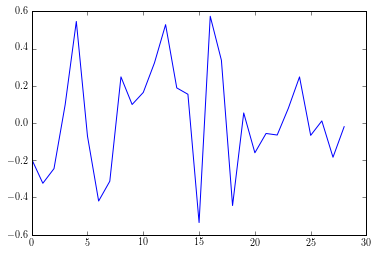

In [97]:
i = 12
j = 24
# cc = find_cc(i,j)
# time_lag_values = np.linspace(0,15,213)
# bins = np.linspace(0,15,15)
# cc_means= np.histogram(time_lag_values,bins,weights = cc,density = False)[0]/np.histogram(time_lag_values,bins,density = False)[0]
# figure()
# plot(bins[:-1],cc_means)

ccb=find_cc(i,j,binned = 1,bin_no=30)
figure()
plot(ccb)
print cc_means.shape

Log binning

/opt/python/2.7.10/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in divide


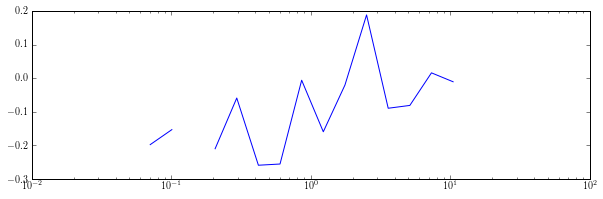

In [52]:
bin_no = 16
time_lag_values = np.linspace(0,15,213)
bins = np.logspace(np.log10(time_lag_values[1]),np.log10(15),bin_no)
cc_means = np.histogram(time_lag_values,bins,weights = cc,density = False)[0]/np.histogram(time_lag_values,bins,density = False)[0]

figure(figsize=(10,3))
semilogx(bins[:-1],cc_means)

In [27]:
%pylab inline
#load sigma noise
bgstd = np.load('./figures/correlation_coeff/backgroundstd.npy')

i = 34
j = 35
#def find_cc(i,j):
fgp1=process_freq_spec(freq_values[i-1],i,draw=0) #-1 if getting i from .txt file. i only needed for plotting
tgp1=transform_to_timelag(fgp1,i-1,draw = 0)
fgp2=process_freq_spec(freq_values[j-1],j,draw=0)
tgp2=transform_to_timelag(fgp2,j-1,draw = 0)

numerator_8 = np.zeros(shape = (0,213))
for k in range(8):
    numerator_8 = np.append(numerator_8,np.array([tgp1[k]*np.conj(tgp2[k])]),0)

numerator = np.real(numerator_8).mean(0)

stdgp1 = find_std(tgp1)
stdgp2 = find_std(tgp2)
denominator = np.sqrt((stdgp1**2-bgstd**2)*(stdgp2**2-bgstd**2))
    
cc = numerator/denominator
    #return cc

# cc = find_cc(34,35)


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


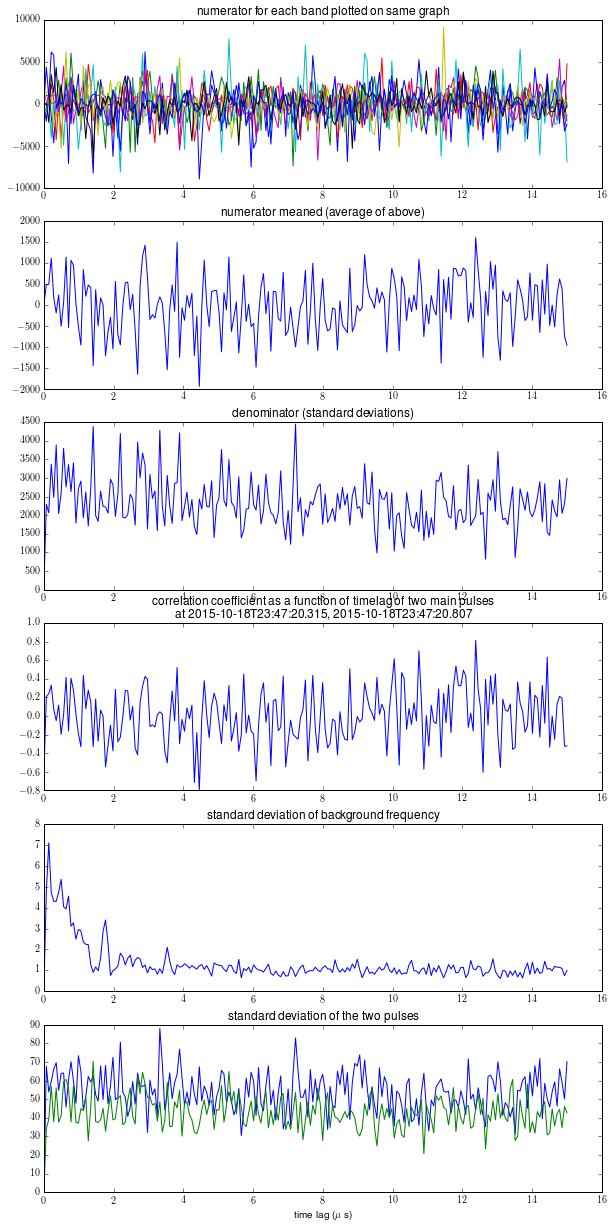

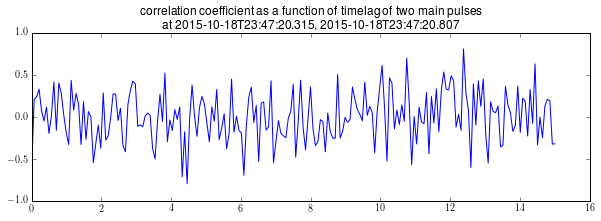

In [28]:
f,axarr=subplots(6,1,figsize=(10,21))
for k in range(8):
    axarr[0].plot(np.linspace(0,15,213),numerator_8[k])
axarr[0].set_title('numerator for each band plotted on same graph')

# figure(figsize=(10,3))
axarr[1].plot(np.linspace(0,15,213),numerator)
axarr[1].set_title('numerator meaned (average of above)')

# figure(figsize=(10,3))
axarr[2].plot(np.linspace(0,15,213),denominator)
axarr[2].set_title('denominator (standard deviations)')

# figure(figsize=(10,3))
axarr[3].plot(np.linspace(0,15,213),cc)
axarr[3].set_title('correlation coefficient as a function of timelag of two main pulses\n at {}, {}'.format(time_values[i-1],time_values[j-1])) 

axarr[4].plot(np.linspace(0,15,213),bgstd)
# axarr[4].set_xlabel(r'time lag ($\mu$ s)')
axarr[4].set_title('standard deviation of background frequency') 

axarr[5].plot(np.linspace(0,15,213),stdgp1)
axarr[5].plot(np.linspace(0,15,213),stdgp2)
axarr[5].set_xlabel(r'time lag ($\mu$ s)')
axarr[5].set_title('standard deviation of the two pulses') 

figure(figsize=(10,3))
plot(np.linspace(0,15,213),cc)
ylim(-1.,1.)
title('correlation coefficient as a function of timelag of two main pulses\n at {}, {}'.format(time_values[i-1],time_values[j-1])) 

In [32]:
a= np.array([1,2,3])
a**2
numerator_8.shape

(8, 213)

Populating the interactive namespace from numpy and matplotlib


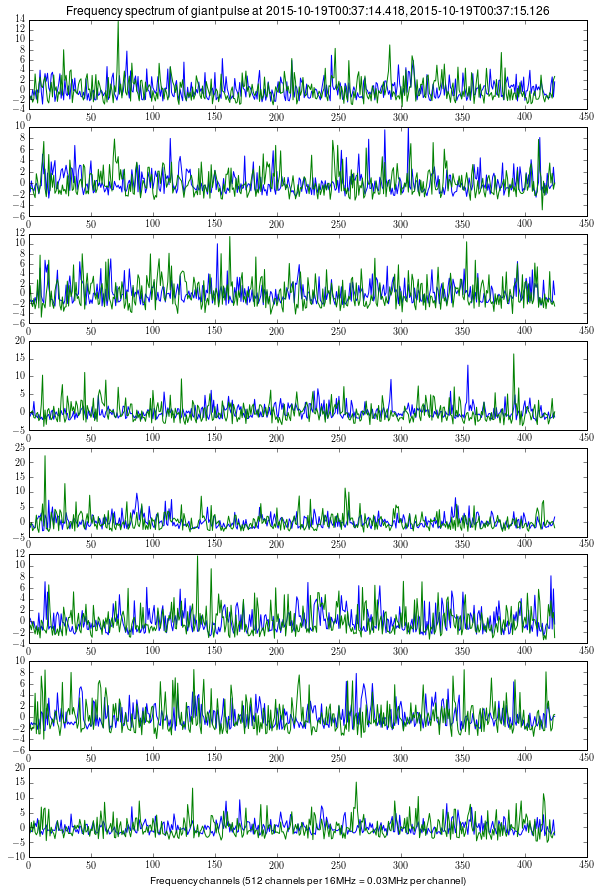

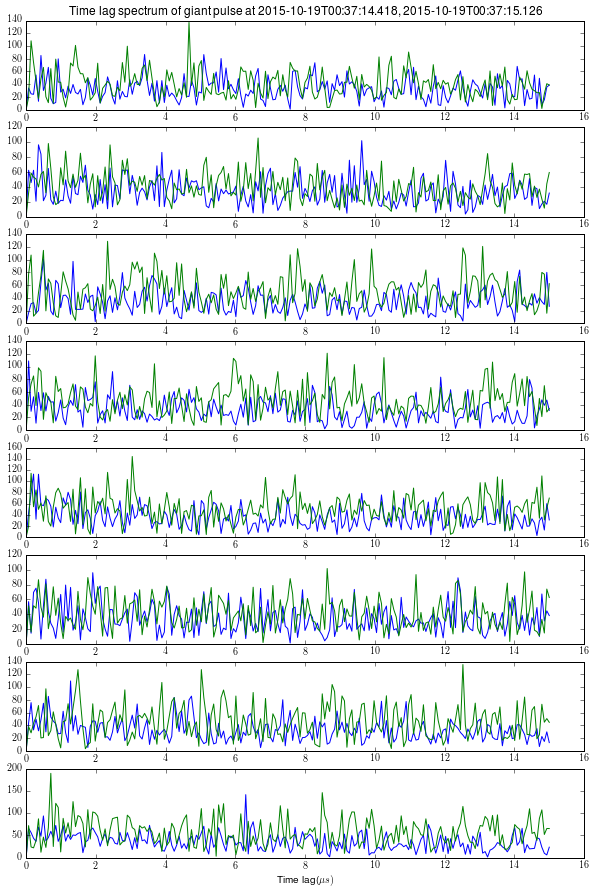

In [54]:
%pylab inline
# i=34
# j=35

fgp1=process_freq_spec(freq_values[i-1],i-1,draw=0)
tgp1=transform_to_timelag(fgp1,i)

fgp2=process_freq_spec(freq_values[j-1],j-1,draw=0)
tgp2=transform_to_timelag(fgp2,j)

plot_2_freq(fgp1,fgp2,[i-1,j-1])
plot_2_timelag(tgp1,tgp2,[i-1,j-1])


In [1]:
tgp66

NameError: name 'tgp66' is not defined

In [59]:
abs(tgp10).shape



(8, 213)